# Word2Vec (Negative Sampling)

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
np.__version__, torch.__version__

('2.0.2', '2.4.1+cu118')

In [3]:
import matplotlib
matplotlib.__version__

'3.9.2'

## 1. Load data

In [4]:
import nltk
from nltk.corpus import brown
nltk.download('brown')

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\acer\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!


True

In [5]:
corpus = brown.sents(categories='news')

In [7]:
corpus = [sent for sent in corpus if len(sent) > 2]
corpus

[['The',
  'Fulton',
  'County',
  'Grand',
  'Jury',
  'said',
  'Friday',
  'an',
  'investigation',
  'of',
  "Atlanta's",
  'recent',
  'primary',
  'election',
  'produced',
  '``',
  'no',
  'evidence',
  "''",
  'that',
  'any',
  'irregularities',
  'took',
  'place',
  '.'],
 ['The',
  'jury',
  'further',
  'said',
  'in',
  'term-end',
  'presentments',
  'that',
  'the',
  'City',
  'Executive',
  'Committee',
  ',',
  'which',
  'had',
  'over-all',
  'charge',
  'of',
  'the',
  'election',
  ',',
  '``',
  'deserves',
  'the',
  'praise',
  'and',
  'thanks',
  'of',
  'the',
  'City',
  'of',
  'Atlanta',
  "''",
  'for',
  'the',
  'manner',
  'in',
  'which',
  'the',
  'election',
  'was',
  'conducted',
  '.'],
 ['The',
  'September-October',
  'term',
  'jury',
  'had',
  'been',
  'charged',
  'by',
  'Fulton',
  'Superior',
  'Court',
  'Judge',
  'Durwood',
  'Pye',
  'to',
  'investigate',
  'reports',
  'of',
  'possible',
  '``',
  'irregularities',
  "''",
 

In [8]:
#2. numeralization
#find unique words
flatten = lambda l: [item for sublist in l for item in sublist]
#assign unique integer
vocabs = list(set(flatten(corpus))) #all the words we have in the system - <UNK>

In [9]:
#create handy mapping between integer and word
word2index = {v:idx for idx, v in enumerate(vocabs)}
word2index['dog']

4578

In [10]:
vocabs.append('<UNK>')
word2index['<UNK>'] = 0

In [11]:
index2word = {v:k for k, v in word2index.items()}
index2word[5]

'Down'

## 2. Prepare train data

In [12]:
def random_batch(batch_size, corpus, window_size=2):
    
    # Make skip gram of one size window
    skip_grams = []
    # loop each word sequence
    # we starts from 1 because 0 has no context
    # we stop at second last for the same reason
    for sent in corpus:
        if len(sent) > 2 * window_size:
                
            for i in range(window_size, len(sent) - window_size):
                target = word2index[sent[i]]
                
                for j in range(-window_size, window_size+1):
                    if j!=0:
                        outside = word2index[sent[i+j]]
                        skip_grams.append([target, outside])
    
    # print(f"Generated {len(skip_grams)} skip-grams with window size {window_size}")

    if len(skip_grams) == 0:
        raise ValueError("No skip-grams generated. Check the corpus and window size")

    
     # Randomly sample a batch of skip-grams
    random_indices = np.random.choice(len(skip_grams), batch_size, replace=False)
    inputs = np.array([skip_grams[i][0] for i in random_indices])
    labels = np.array([skip_grams[i][1] for i in random_indices])
            
    return inputs.reshape(-1, 1), labels.reshape(-1, 1)

In [13]:
x, y = random_batch(2, corpus)

x.shape  #batch_size, 1


(2, 1)

In [14]:
x

array([[ 778],
       [7833]])

In [15]:
y.shape  #batch_size 1

(2, 1)

## 3. Negative Sampling

### Unigram distribution

$$P(w)=U(w)^{3/4}/Z$$

In [16]:
z = 0.001

In [17]:
#count
from collections import Counter

word_count = Counter(flatten(corpus))
word_count

#get the total number of words
num_total_words = sum([c for w, c in word_count.items()])
num_total_words

100351

In [18]:
vocabs

['qualifications',
 'Heights',
 '2.325%',
 'Indications',
 'pricking',
 'Down',
 '7.19',
 'Nanook',
 'although',
 'threatened',
 'welfare',
 'Quaker',
 'Hewlett-Woodmere',
 'disallowed',
 'situations',
 'painted',
 'expects',
 'drums',
 'returned',
 'friendly',
 'production',
 'laws',
 'assembly',
 'Mickey',
 'weapon',
 'coat',
 'achieved',
 '280-yard',
 'Browning',
 'Silvers',
 'envisaged',
 'clearance',
 "symphony's",
 'Fanning',
 'College',
 'money-winner',
 'Consolidated',
 'Yuri',
 "car's",
 'enlarge',
 '88',
 'maids',
 'Building',
 'parks',
 'balconies',
 'suggestion',
 'industrialized',
 'decoration',
 'Vickery',
 'deliver',
 '5777',
 'attracted',
 'consult',
 'Tucson',
 'Indianapolis',
 'slate',
 'earned',
 '4-1/2%',
 'Music',
 'generally',
 'expanding',
 'rich',
 'Williams',
 'subpenaed',
 'pre-season',
 "High's",
 'loser',
 '$2',
 'Patricia',
 'bustling',
 'Cavaliere',
 'sending',
 'Morley',
 'Shortstop',
 'Stacy',
 'magenta',
 'Emma',
 'Commies',
 'what',
 'earliest',
 'thus

$$P(w)=U(w)^{3/4}/Z$$

In [19]:
unigram_table = []

for v in vocabs:
    uw = word_count[v] / num_total_words
    uw_alpha = int((uw ** 0.75) / z)
    unigram_table.extend([v] * uw_alpha)
    
Counter(unigram_table)

Counter({'the': 114,
         ',': 108,
         '.': 89,
         'of': 69,
         'to': 55,
         'and': 55,
         'a': 52,
         'in': 50,
         'for': 30,
         'that': 26,
         'The': 26,
         "''": 24,
         '``': 24,
         'was': 24,
         'is': 24,
         'on': 23,
         'at': 21,
         'with': 20,
         'be': 19,
         'as': 18,
         'by': 18,
         'he': 17,
         'his': 15,
         'will': 15,
         'said': 15,
         'it': 14,
         'from': 14,
         'are': 13,
         ';': 13,
         'has': 12,
         '--': 12,
         'an': 12,
         'had': 12,
         'who': 11,
         'Mrs.': 11,
         'were': 11,
         'not': 11,
         'have': 11,
         'this': 11,
         'which': 10,
         'their': 10,
         'would': 10,
         'been': 9,
         'they': 9,
         'He': 9,
         'one': 8,
         '(': 8,
         'or': 8,
         ')': 8,
         'out': 8,
         'but': 8,

## 4. Model

$$\mathbf{J}_{\text{neg-sample}}(\mathbf{v}_c,o,\mathbf{U})=-\log(\sigma(\mathbf{u}_o^T\mathbf{v}_c))-\sum_{k=1}^K\log(\sigma(-\mathbf{u}_k^T\mathbf{v}_c))$$

In [20]:
def prepare_sequence(seq, word2index):
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index['<UNK>'], seq))
    return torch.LongTensor(idxs)

In [21]:
import random

def negative_sampling(targets, unigram_table, k):
    batch_size = targets.shape[0]
    neg_samples = []
    for i in range(batch_size):  #(1, k)
        target_index = targets[i].item()
        nsample      = []
        while (len(nsample) < k):
            neg = random.choice(unigram_table)
            if word2index[neg] == target_index:
                continue
            nsample.append(neg)
        neg_samples.append(prepare_sequence(nsample, word2index).reshape(1, -1))
        
    return torch.cat(neg_samples) #batch_size, k

In [22]:
batch_size = 128
window_size = 4
x, y = random_batch(batch_size, corpus, window_size )
x_tensor = torch.LongTensor(x)
y_tensor = torch.LongTensor(y)

In [23]:
k = 5
neg_samples = negative_sampling(y_tensor, unigram_table, k)

In [24]:
y_tensor[1]

tensor([13176])

In [25]:
neg_samples[1]

tensor([12605, 10619,  6026,  7630, 13044])

$$\mathbf{J}_{\text{neg-sample}}(\mathbf{v}_c,o,\mathbf{U})=-\log(\sigma(\mathbf{u}_o^T\mathbf{v}_c))-\sum_{k=1}^K\log(\sigma(-\mathbf{u}_k^T\mathbf{v}_c))$$

In [26]:
class SkipgramNeg(nn.Module):
    
    def __init__(self, voc_size, emb_size):
        super(SkipgramNeg, self).__init__()
        self.embedding_center  = nn.Embedding(voc_size, emb_size)
        self.embedding_outside = nn.Embedding(voc_size, emb_size)
        self.logsigmoid        = nn.LogSigmoid()
    
    def forward(self, center, outside, negative):
        #center, outside:  (bs, 1)
        #negative       :  (bs, k)
        
        center_embed   = self.embedding_center(center) #(bs, 1, emb_size)
        outside_embed  = self.embedding_outside(outside) #(bs, 1, emb_size)
        negative_embed = self.embedding_outside(negative) #(bs, k, emb_size)
        
        uovc           = outside_embed.bmm(center_embed.transpose(1, 2)).squeeze(2) #(bs, 1)
        ukvc           = -negative_embed.bmm(center_embed.transpose(1, 2)).squeeze(2) #(bs, k)
        ukvc_sum       = torch.sum(ukvc, 1).reshape(-1, 1) #(bs, 1)
        
        loss           = self.logsigmoid(uovc) + self.logsigmoid(ukvc_sum)
        
        return -torch.mean(loss)

In [27]:
#test your model
emb_size = 2
voc_size = len(vocabs)
model = SkipgramNeg(voc_size, emb_size)

In [28]:
loss = model(x_tensor, y_tensor, neg_samples)

In [29]:
loss

tensor(2.1148, grad_fn=<NegBackward0>)

## 5. Training

In [30]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [31]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_min = int(elapsed_time / 60)
    elapsed_sec = int(elapsed_time - (elapsed_min * 60))
    return elapsed_min, elapsed_sec

In [33]:
import time
num_epochs = 100
batch_size = 128
window_sizes = [2,4,6]

for window_size in window_sizes:
    print(f"Training with window size = {window_size}\n")

    for epoch in range(num_epochs):
        start = time.time()
        
        #get batch
        input_batch, label_batch = random_batch(batch_size, corpus)
        input_tensor = torch.LongTensor(input_batch)
        label_tensor = torch.LongTensor(label_batch)
        
        #predict
        neg_samples = negative_sampling(label_tensor, unigram_table, k)
        loss = model(input_tensor, label_tensor, neg_samples)
        
        #backprogate
        optimizer.zero_grad()
        loss.backward()
        
        #update alpha
        optimizer.step()

        end = time.time()
        epoch_mins, epoch_sec = epoch_time(start, end)
        
        #print the loss
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1:6.0f} | Loss: {loss:2.6f} | time: {epoch_mins}m {epoch_sec}s")
    
    print(f"Completed training with window size: {window_size}\n")

Training with window size = 2

Epoch     10 | Loss: 1.766605 | time: 0m 0s
Epoch     20 | Loss: 1.805360 | time: 0m 0s
Epoch     30 | Loss: 1.687108 | time: 0m 0s
Epoch     40 | Loss: 1.960058 | time: 0m 0s
Epoch     50 | Loss: 1.745413 | time: 0m 0s
Epoch     60 | Loss: 1.725329 | time: 0m 0s
Epoch     70 | Loss: 1.730637 | time: 0m 0s
Epoch     80 | Loss: 1.700475 | time: 0m 0s
Epoch     90 | Loss: 1.688064 | time: 0m 0s
Epoch    100 | Loss: 1.647582 | time: 0m 0s
Completed training with window size: 2

Training with window size = 4

Epoch     10 | Loss: 1.666491 | time: 0m 0s
Epoch     20 | Loss: 1.785416 | time: 0m 0s
Epoch     30 | Loss: 1.681622 | time: 0m 0s
Epoch     40 | Loss: 1.605645 | time: 0m 0s
Epoch     50 | Loss: 1.683308 | time: 0m 0s
Epoch     60 | Loss: 1.615331 | time: 0m 0s
Epoch     70 | Loss: 1.583654 | time: 0m 0s
Epoch     80 | Loss: 1.722816 | time: 0m 0s
Epoch     90 | Loss: 1.867056 | time: 0m 0s
Epoch    100 | Loss: 1.821580 | time: 0m 0s
Completed training

## 6. Plot the embeddings

In [34]:
vocabs

['qualifications',
 'Heights',
 '2.325%',
 'Indications',
 'pricking',
 'Down',
 '7.19',
 'Nanook',
 'although',
 'threatened',
 'welfare',
 'Quaker',
 'Hewlett-Woodmere',
 'disallowed',
 'situations',
 'painted',
 'expects',
 'drums',
 'returned',
 'friendly',
 'production',
 'laws',
 'assembly',
 'Mickey',
 'weapon',
 'coat',
 'achieved',
 '280-yard',
 'Browning',
 'Silvers',
 'envisaged',
 'clearance',
 "symphony's",
 'Fanning',
 'College',
 'money-winner',
 'Consolidated',
 'Yuri',
 "car's",
 'enlarge',
 '88',
 'maids',
 'Building',
 'parks',
 'balconies',
 'suggestion',
 'industrialized',
 'decoration',
 'Vickery',
 'deliver',
 '5777',
 'attracted',
 'consult',
 'Tucson',
 'Indianapolis',
 'slate',
 'earned',
 '4-1/2%',
 'Music',
 'generally',
 'expanding',
 'rich',
 'Williams',
 'subpenaed',
 'pre-season',
 "High's",
 'loser',
 '$2',
 'Patricia',
 'bustling',
 'Cavaliere',
 'sending',
 'Morley',
 'Shortstop',
 'Stacy',
 'magenta',
 'Emma',
 'Commies',
 'what',
 'earliest',
 'thus

In [35]:
laws = torch.LongTensor([word2index['laws']])
laws

tensor([21])

In [36]:
laws_embed_c = model.embedding_center(laws)
laws_embed_o = model.embedding_outside(laws)
laws_embed   = (laws_embed_c + laws_embed_o) / 2
laws_embed

tensor([[ 0.4391, -0.1120]], grad_fn=<DivBackward0>)

In [37]:
laws_embed_o

tensor([[ 0.2566, -0.2837]], grad_fn=<EmbeddingBackward0>)

In [38]:
def get_embed(word):
    try:
        index = word2index[word]
    except:
        index = word2index['<UNK>']
        
    word = torch.LongTensor([word2index[word]])
    
    embed_c = model.embedding_center(word)
    embed_o = model.embedding_outside(word)
    embed   = (embed_c + embed_o) / 2
    
    return embed[0][0].item(), embed[0][1].item()

In [39]:
get_embed('laws')

(0.43906575441360474, -0.11203426867723465)

In [40]:
get_embed('although')

(0.4447695314884186, -0.325581818819046)

In [41]:
get_embed('Heights')

(-0.0636206865310669, 0.6180993914604187)

In [43]:
get_embed('disallowed')

(0.10037297010421753, -0.9300647974014282)

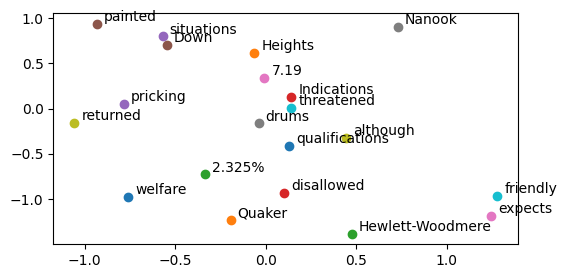

In [45]:
plt.figure(figsize=(6, 3))
for i, word in enumerate(vocabs[:20]):
    x, y = get_embed(word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.show()

## 7. Cosine similarity

In [46]:
laws = get_embed('laws')
laws

(0.43906575441360474, -0.11203426867723465)

In [47]:
although = get_embed('although')
although

(0.4447695314884186, -0.325581818819046)

In [48]:
Heights = get_embed('Heights')
Heights

(-0.0636206865310669, 0.6180993914604187)

In [49]:
np.array(laws) @ np.array(although)

np.float64(0.23175939084914376)

In [50]:
#more formally is to divide by its norm
def cosine_similarity(A, B):
    dot_product = np.dot(A, B)
    norm_a = np.linalg.norm(A)
    norm_b = np.linalg.norm(B)
    similarity = dot_product / (norm_a * norm_b)
    return similarity

print(cosine_similarity(np.array(laws), np.array(although)))
print(cosine_similarity(np.array(laws), np.array(although)))

0.9278975944812892
0.9278975944812892
